# Table of Contents
<a id="table-of-contents"></a>
* [1. Introduction](#1)
* [2. General](#2)
    * [2.1. Numbers of rows and columns](#2.1)
    * [2.2. Numbers of missing values](#2.2)
    * [2.3. First 5 rows](#2.3)
    * [2.4. Basic statistics on continuous features](#2.4)
    * [2.5. Count on categorical features](#2.5)
    * [2.6. Target variables](#2.6)
* [3. Features & Target Relation](#3)
    * [3.1. Continuous features](#3.1)
    * [3.2. Categorical features](#3.2)
* [4. Baseline Model](#4)
    * [4.1 Preparation](#4.1)
    * [4.2 Catboost baseline model](#4.2)
    * [4.3 XGBoost baseline model](#4.3)
    * [4.4 LGBM baseline model](#4.4)
    * [4.5 Average baseline model](#4.5)
* [5. Tuned Model](#5)
    * [5.1 Catboost tuned model](#5.1)
    * [5.2 XGBoost tuned model](#5.2)
    * [5.3 LGBM tuned model](#5.3)
    * [5.4 Average tuned model](#5.4)
* [6. Winners Solutions](#6)

# 1. Introduction

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

from scipy import stats
from scipy.stats import rankdata, norm

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR, NuSVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import *

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
import time, os, warnings, random, string, re, gc, sys

import category_encoders as ce

import lightgbm as lgb
import catboost as cb


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
train_df = pd.read_csv('../data/original/train.csv')
test_df = pd.read_csv('../data/original/test.csv')

In [3]:
# カテゴリ変数と数値変数を抜き出せるようにする
cat_features = ["cat" + str(i) for i in range(10)]
num_features = ["cont" + str(i) for i in range(14)]

In [20]:
cat_features

['cat0',
 'cat1',
 'cat2',
 'cat3',
 'cat4',
 'cat5',
 'cat6',
 'cat7',
 'cat8',
 'cat9']

[back to top](#table-of-contents)
<a id="2.1"></a>
## 2.1. Numbers of rows and columns

In [4]:
print('Rows and Columns in train dataset:', train_df.shape)
print('Rows and Columns in test dataset:', test_df.shape)

Rows and Columns in train dataset: (300000, 26)
Rows and Columns in test dataset: (200000, 25)


昨日のEDAと結果一致

In [5]:
print('Missing values in train dataset:', sum(train_df.isnull().sum()))
print('Missing values in test dataset:', sum(test_df.isnull().sum()))

Missing values in train dataset: 0
Missing values in test dataset: 0


結果一致

In [6]:
train_df.head(10)

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
0,1,B,B,B,C,B,B,A,E,C,N,0.201470,-0.014822,0.669699,0.136278,0.610706,0.400361,0.160266,0.310921,0.389470,0.267559,0.237281,0.377873,0.322401,0.869850,8.113634
1,2,B,B,A,A,B,D,A,F,A,O,0.743068,0.367411,1.021605,0.365798,0.276853,0.533087,0.558922,0.516294,0.594928,0.341439,0.906013,0.921701,0.261975,0.465083,8.481233
2,3,A,A,A,C,B,D,A,D,A,F,0.742708,0.310383,-0.012673,0.576957,0.285074,0.650609,0.375348,0.902567,0.555205,0.843531,0.748809,0.620126,0.541474,0.763846,8.364351
3,4,B,B,A,C,B,D,A,E,C,K,0.429551,0.620998,0.577942,0.280610,0.284667,0.668980,0.239061,0.732948,0.679618,0.574844,0.346010,0.714610,0.540150,0.280682,8.049253
4,6,A,A,A,C,B,D,A,E,A,N,1.058291,0.367492,-0.052389,0.232407,0.287595,0.686964,0.420667,0.648182,0.684501,0.956692,1.000773,0.776742,0.625849,0.250823,7.972260
5,7,A,B,A,C,B,D,A,E,G,F,0.402056,0.837058,0.737991,0.778429,0.530250,0.392432,0.658169,0.997473,0.569874,0.960864,0.238050,0.316065,0.731729,0.694719,8.028558
6,8,B,A,A,A,B,D,A,E,C,F,0.743661,0.234794,0.339026,0.424034,0.281511,0.396705,0.273454,0.824573,0.656325,0.677114,0.808445,0.615973,0.631677,0.283561,7.811465
7,9,A,A,A,C,B,B,A,E,A,M,0.887959,0.482799,0.674588,0.584811,0.763081,0.633353,0.339760,0.802006,1.010997,0.391221,0.057297,0.591120,0.074629,0.775869,7.674188
8,10,A,B,A,C,B,D,A,E,G,I,0.523472,0.492059,0.165440,0.749995,0.281110,0.472564,0.414036,0.809142,1.013301,0.761183,1.041711,0.393960,0.782381,0.865610,8.090095
9,11,A,A,A,A,B,B,A,E,E,M,0.503013,0.551163,0.622871,0.471560,0.287109,0.425716,0.233705,0.493036,0.353048,0.334675,0.085087,0.230634,0.636732,0.291874,8.446155


一致

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 26 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      300000 non-null  int64  
 1   cat0    300000 non-null  object 
 2   cat1    300000 non-null  object 
 3   cat2    300000 non-null  object 
 4   cat3    300000 non-null  object 
 5   cat4    300000 non-null  object 
 6   cat5    300000 non-null  object 
 7   cat6    300000 non-null  object 
 8   cat7    300000 non-null  object 
 9   cat8    300000 non-null  object 
 10  cat9    300000 non-null  object 
 11  cont0   300000 non-null  float64
 12  cont1   300000 non-null  float64
 13  cont2   300000 non-null  float64
 14  cont3   300000 non-null  float64
 15  cont4   300000 non-null  float64
 16  cont5   300000 non-null  float64
 17  cont6   300000 non-null  float64
 18  cont7   300000 non-null  float64
 19  cont8   300000 non-null  float64
 20  cont9   300000 non-null  float64
 21  cont10  30

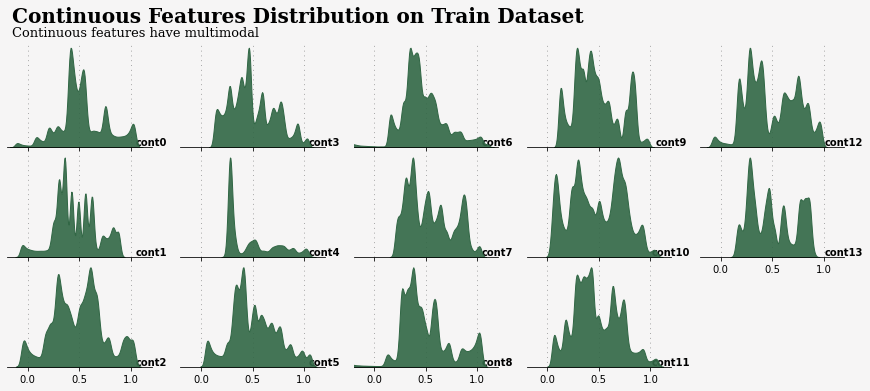

In [15]:
fig = plt.figure(figsize=(15, 10), facecolor='#f6f5f5')
gs = fig.add_gridspec(5, 5)
gs.update(wspace=0.2, hspace=0.05)

background_color = "#f6f5f5"

run_no = 0
for col in range(0, 5):
    for row in range(0, 3):
        locals()["ax"+str(run_no)] = fig.add_subplot(gs[row, col])
        locals()["ax"+str(run_no)].set_facecolor(background_color)
        locals()["ax"+str(run_no)].set_yticklabels([])
        locals()["ax"+str(run_no)].tick_params(axis='y', which=u'both',length=0)
        for s in ["top","right", 'left']:
            locals()["ax"+str(run_no)].spines[s].set_visible(False)
        run_no += 1

ax0.text(-0.15, 4.5, 'Continuous Features Distribution on Train Dataset', fontsize=20, fontweight='bold', fontfamily='serif')
ax0.text(-0.15, 4, 'Continuous features have multimodal', fontsize=13, fontweight='light', fontfamily='serif')        

run_no = 0
for col in num_features:
    sns.kdeplot(train_df[col], ax=locals()["ax"+str(run_no)], shade=True, color='#316745', alpha=0.9, zorder=2)
    locals()["ax"+str(run_no)].grid(which='major', axis='x', zorder=0, color='gray', linestyle=':', dashes=(1,5))
    locals()["ax"+str(run_no)].set_ylabel(col, fontsize=10, fontweight='bold').set_rotation(0)
    locals()["ax"+str(run_no)].yaxis.set_label_coords(1, 0)
    locals()["ax"+str(run_no)].set_xlim(-0.2, 1.2)
    locals()["ax"+str(run_no)].set_xlabel('')
    run_no += 1
    
ax14.remove()

In [17]:
train_df[num_features].describe()

,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
count,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000
mean,0.527335,0.460926,0.490498,0.496689,0.491654,0.510526,0.467476,0.537119,0.498456,0.474872,0.474492,0.473216,0.494561,0.508273
std,0.230599,0.214003,0.253346,0.219199,0.240074,0.228232,0.210331,0.218140,0.239920,0.218007,0.255949,0.222022,0.247292,0.222950
min,-0.118039,-0.069309,-0.056104,0.130676,0.255908,0.045915,-0.224689,0.203763,-0.260275,0.117896,0.048732,0.052608,-0.074208,0.151050
25%,0.405965,0.310494,0.300604,0.329783,0.284188,0.354141,0.342873,0.355825,0.332486,0.306874,0.276017,0.308151,0.289074,0.300669
50%,0.497053,0.427903,0.502462,0.465026,0.390470,0.488865,0.429383,0.504661,0.439151,0.434620,0.459975,0.433812,0.422887,0.472400
75%,0.668060,0.615113,0.647512,0.664451,0.696599,0.669625,0.573383,0.703441,0.606056,0.614333,0.691579,0.642057,0.714502,0.758447
max,1.058443,0.887253,1.034704,1.039560,1.055424,1.067649,1.111552,1.032837,1.040229,0.982922,1.055960,1.071444,0.975035,0.905992


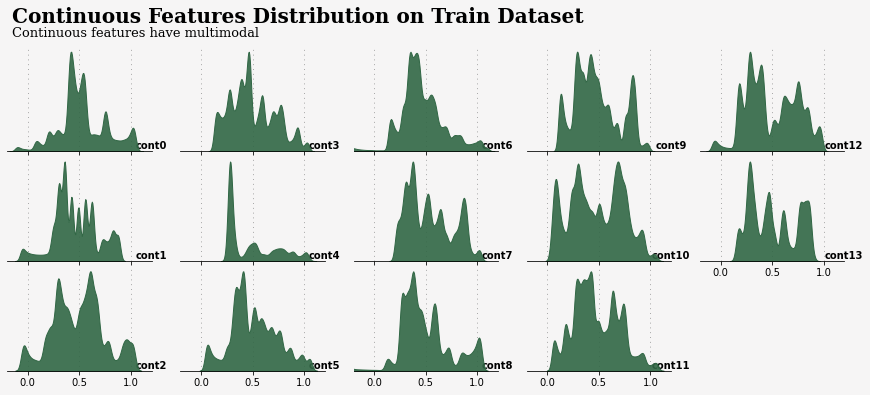

In [18]:
fig = plt.figure(figsize=(15, 10), facecolor='#f6f5f5')
gs = fig.add_gridspec(5, 5)
gs.update(wspace=0.2, hspace=0.05)

background_color = "#f6f5f5"

run_no = 0
for col in range(0, 5):
    for row in range(0, 3):
        locals()["ax"+str(run_no)] = fig.add_subplot(gs[row, col])
        locals()["ax"+str(run_no)].set_facecolor(background_color)
        locals()["ax"+str(run_no)].set_yticklabels([])
        locals()["ax"+str(run_no)].tick_params(axis='y', which=u'both',length=0)
        for s in ["top","right", 'left']:
            locals()["ax"+str(run_no)].spines[s].set_visible(False)
        run_no += 1

ax0.text(-0.15, 4.5, 'Continuous Features Distribution on Train Dataset', fontsize=20, fontweight='bold', fontfamily='serif')
ax0.text(-0.15, 4, 'Continuous features have multimodal', fontsize=13, fontweight='light', fontfamily='serif')        

run_no = 0
for col in num_features:
    sns.kdeplot(test_df[col], ax=locals()["ax"+str(run_no)], shade=True, color='#316745', alpha=0.9, zorder=2)
    locals()["ax"+str(run_no)].grid(which='major', axis='x', zorder=0, color='gray', linestyle=':', dashes=(1,5))
    locals()["ax"+str(run_no)].set_ylabel(col, fontsize=10, fontweight='bold').set_rotation(0)
    locals()["ax"+str(run_no)].yaxis.set_label_coords(1, 0)
    locals()["ax"+str(run_no)].set_xlim(-0.2, 1.2)
    locals()["ax"+str(run_no)].set_xlabel('')
    run_no += 1
    
ax14.remove()

In [19]:
test_df[num_features].describe()

,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.526858,0.460882,0.491686,0.496263,0.492200,0.509944,0.468050,0.537617,0.497587,0.474630,0.473625,0.473589,0.492756,0.508303
std,0.230506,0.213896,0.252852,0.219304,0.240251,0.228100,0.210167,0.218197,0.239337,0.217558,0.255307,0.221844,0.247105,0.222977
min,-0.117993,-0.069316,-0.056095,0.130655,0.255903,0.045921,-0.224613,0.203763,-0.260236,0.117894,0.048734,0.052615,-0.074201,0.151052
25%,0.405787,0.310536,0.302189,0.328865,0.284188,0.353682,0.342813,0.356482,0.332762,0.306940,0.274991,0.308495,0.288094,0.300697
50%,0.496602,0.427656,0.503075,0.464590,0.395080,0.488378,0.429819,0.505216,0.438716,0.434610,0.460042,0.433857,0.422065,0.472446
75%,0.666389,0.615041,0.648234,0.663401,0.697252,0.668586,0.573861,0.703289,0.605368,0.610768,0.690143,0.642201,0.711038,0.758496
max,1.058434,0.887253,1.034687,1.039558,1.055423,1.067641,1.111540,1.032823,1.040208,0.982928,1.055955,1.071445,0.975032,0.906013


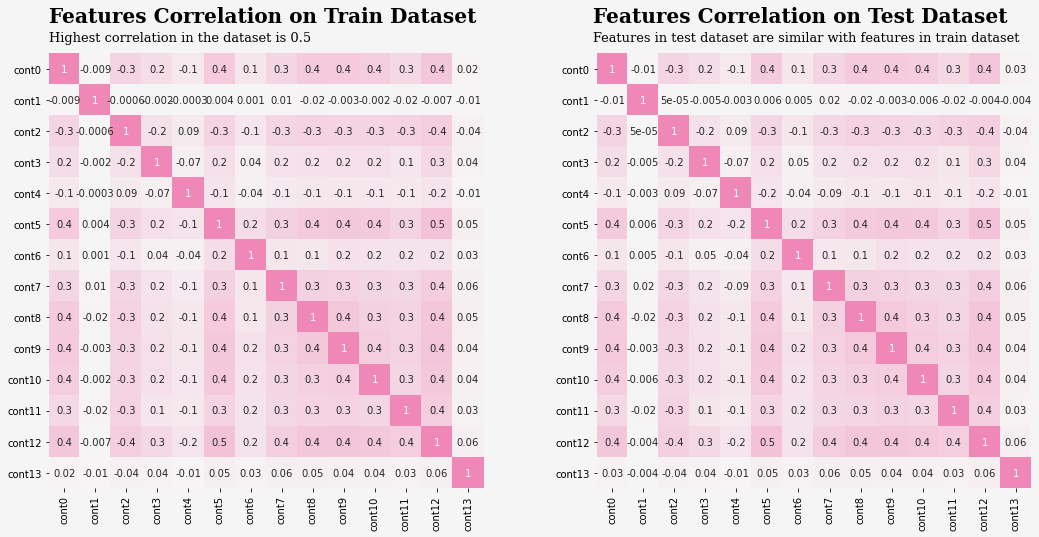

In [21]:
background_color = "#f6f5f5"

fig = plt.figure(figsize=(18, 8), facecolor=background_color)
gs = fig.add_gridspec(1, 2)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
colors = ["#f088b7", "#f6f5f5","#f088b7"]
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

ax0.set_facecolor(background_color)
ax0.text(0, -1, 'Features Correlation on Train Dataset', fontsize=20, fontweight='bold', fontfamily='serif')
ax0.text(0, -0.4, 'Highest correlation in the dataset is 0.5', fontsize=13, fontweight='light', fontfamily='serif')

ax1.set_facecolor(background_color)
ax1.text(-0.1, -1, 'Features Correlation on Test Dataset', fontsize=20, fontweight='bold', fontfamily='serif')
ax1.text(-0.1, -0.4, 'Features in test dataset are similar with features in train dataset ', 
         fontsize=13, fontweight='light', fontfamily='serif')

sns.heatmap(train_df[num_features].corr(), ax=ax0, vmin=-1, vmax=1, annot=True, square=True, 
            cbar_kws={"orientation": "horizontal"}, cbar=False, cmap=colormap, fmt='.1g')

sns.heatmap(test_df[num_features].corr(), ax=ax1, vmin=-1, vmax=1, annot=True, square=True, 
            cbar_kws={"orientation": "horizontal"}, cbar=False, cmap=colormap, fmt='.1g')

plt.show()

[back to top](#table-of-contents)
<a id="2.5"></a>
## 2.5. Categorical features proportion
**Train dataset**
- カテゴリ変数の各項目の値をみてみる

In [25]:
for c in range(0,10):
    display(train_df['cat'+str(c)].value_counts())

A    193130
B    106870
Name: cat0, dtype: int64

A    154824
B    145176
Name: cat1, dtype: int64

A    253886
B     46114
Name: cat2, dtype: int64

C    263356
A     31726
D      4328
B       590
Name: cat3, dtype: int64

B    294737
A      2978
C      1772
D       513
Name: cat4, dtype: int64

B    149340
D    126137
C     20248
A      4275
Name: cat5, dtype: int64

A    290511
B      8018
C       928
D       292
I       136
H        56
E        45
G        14
Name: cat6, dtype: int64

E    276040
D     12144
B      8297
G      2870
F       562
C        36
A        31
I        20
Name: cat7, dtype: int64

C    111103
E     79844
A     76585
G     26128
D      5187
F       966
B       187
Name: cat8, dtype: int64

F    71249
I    59218
G    28253
L    20958
H    19925
K    18057
N    16704
B    14477
J    14266
O    14203
A    11029
M     7931
C     1603
D     1088
E     1039
Name: cat9, dtype: int64

ちょっと減らしてみる

In [27]:
cat6_category = list(pd.DataFrame(train_df['cat6'].value_counts()/len(train_df['cat6'])*100)[:1].index)
cat7_category = list(pd.DataFrame(train_df['cat7'].value_counts()/len(train_df['cat7'])*100)[:3].index)
cat8_category = list(pd.DataFrame(train_df['cat8'].value_counts()/len(train_df['cat8'])*100)[:4].index)
train_df['cat6'] = np.where(~train_df['cat6'].isin(cat6_category), 'Others', train_df['cat6'])
train_df['cat7'] = np.where(~train_df['cat7'].isin(cat7_category), 'Others', train_df['cat7'])
train_df['cat8'] = np.where(~train_df['cat8'].isin(cat8_category), 'Others', train_df['cat8'])

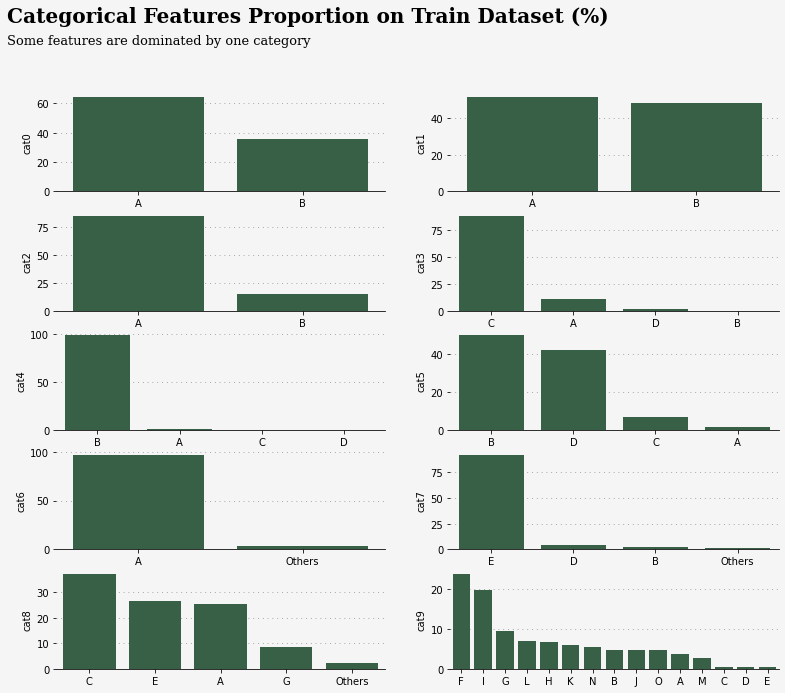

In [31]:
background_color = "#f6f5f5"

fig = plt.figure(figsize=(20, 15), facecolor=background_color)
gs = fig.add_gridspec(7, 3)
gs.update(wspace=0.2, hspace=0.2)

run_no = 0
for row in range(0, 5):
    for col in range(0, 2):
        locals()["ax"+str(run_no)] = fig.add_subplot(gs[row, col])
        locals()["ax"+str(run_no)].set_facecolor(background_color)
        for s in ["top","right", 'left']:
            locals()["ax"+str(run_no)].spines[s].set_visible(False)
        run_no += 1

ax0.text(-0.8, 115, 'Categorical Features Proportion on Train Dataset (%)', fontsize=20, fontweight='bold', fontfamily='serif')
ax0.text(-0.8, 100, 'Some features are dominated by one category', fontsize=13, fontweight='light', fontfamily='serif')        

run_no = 0
for col in cat_features:
    chart_df = pd.DataFrame(train_df[col].value_counts() / len(train_df) * 100)
    sns.barplot(x=chart_df.index, y=chart_df[col], ax=locals()["ax"+str(run_no)], color='#316745', zorder=2)
    locals()["ax"+str(run_no)].grid(which='major', axis='y', zorder=0, color='gray', linestyle=':', dashes=(1,5))
    run_no += 1
    


In [32]:
for c in range(0,10):
    display(test_df['cat'+str(c)].value_counts())

A    128830
B     71170
Name: cat0, dtype: int64

A    103174
B     96826
Name: cat1, dtype: int64

A    169377
B     30623
Name: cat2, dtype: int64

C    175480
A     21317
D      2815
B       388
Name: cat3, dtype: int64

B    196535
A      1919
C      1174
D       372
Name: cat4, dtype: int64

B    100175
D     83641
C     13380
A      2804
Name: cat5, dtype: int64

A    193519
B      5520
C       593
D       198
I        92
H        34
E        34
G        10
Name: cat6, dtype: int64

E    183796
D      8294
B      5572
G      1910
F       372
C        32
A        20
I         4
Name: cat7, dtype: int64

C    74310
E    53526
A    50721
G    17373
D     3317
F      648
B      105
Name: cat8, dtype: int64

F    46984
I    39478
G    18636
L    13878
H    13762
K    12349
N    11338
B     9632
O     9425
J     9381
A     7440
M     5157
C     1091
D      743
E      706
Name: cat9, dtype: int64

cat6にGあるので、日本語noteは誤りの模様

In [33]:
cat6_category = list(pd.DataFrame(test_df['cat6'].value_counts()/len(test_df['cat6'])*100)[:1].index)
cat7_category = list(pd.DataFrame(test_df['cat7'].value_counts()/len(test_df['cat7'])*100)[:3].index)
cat8_category = list(pd.DataFrame(test_df['cat8'].value_counts()/len(test_df['cat8'])*100)[:4].index)
test_df['cat6'] = np.where(~test_df['cat6'].isin(cat6_category), 'Others', test_df['cat6'])
test_df['cat7'] = np.where(~test_df['cat7'].isin(cat7_category), 'Others', test_df['cat7'])
test_df['cat8'] = np.where(~test_df['cat8'].isin(cat8_category), 'Others', test_df['cat8'])

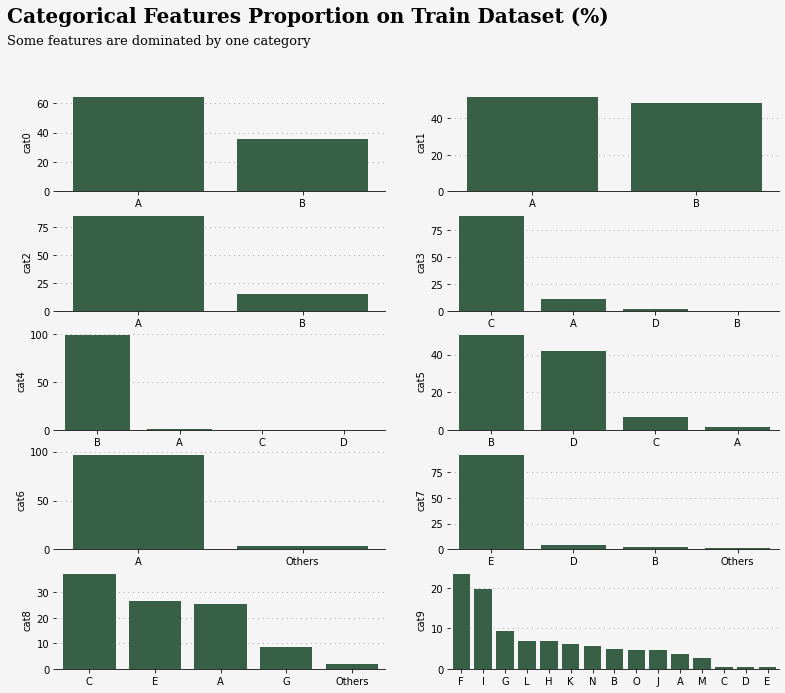

In [35]:
background_color = "#f6f5f5"

fig = plt.figure(figsize=(20, 15), facecolor=background_color)
gs = fig.add_gridspec(7, 3)
gs.update(wspace=0.2, hspace=0.2)

run_no = 0
for row in range(0, 5):
    for col in range(0, 2):
        locals()["ax"+str(run_no)] = fig.add_subplot(gs[row, col])
        locals()["ax"+str(run_no)].set_facecolor(background_color)
        for s in ["top","right", 'left']:
            locals()["ax"+str(run_no)].spines[s].set_visible(False)
        run_no += 1

ax0.text(-0.8, 115, 'Categorical Features Proportion on Train Dataset (%)', fontsize=20, fontweight='bold', fontfamily='serif')
ax0.text(-0.8, 100, 'Some features are dominated by one category', fontsize=13, fontweight='light', fontfamily='serif')        

run_no = 0
for col in cat_features:
    chart_df = pd.DataFrame(test_df[col].value_counts() / len(test_df) * 100)
    sns.barplot(x=chart_df.index, y=chart_df[col], ax=locals()["ax"+str(run_no)], color='#316745', zorder=2)
    locals()["ax"+str(run_no)].grid(which='major', axis='y', zorder=0, color='gray', linestyle=':', dashes=(1,5))
    run_no += 1

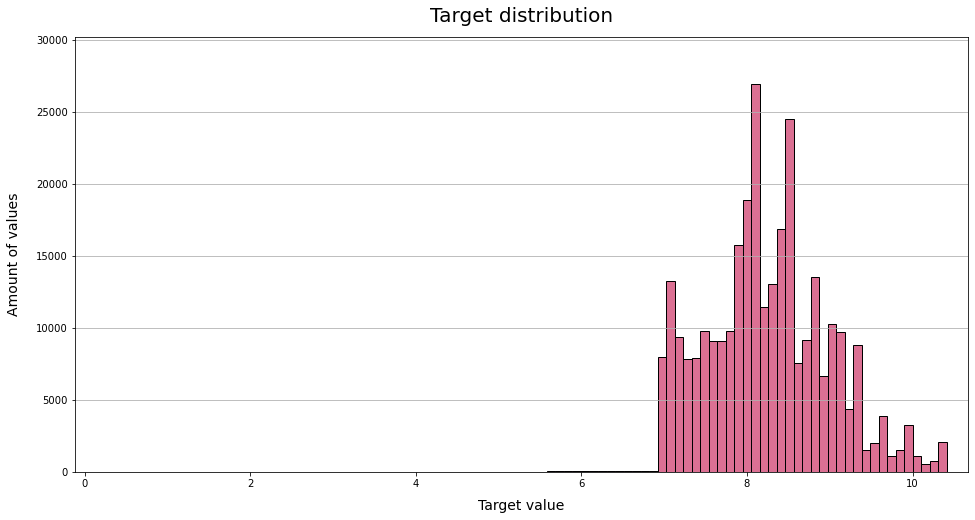

In [36]:
fig, ax = plt.subplots(figsize=(16, 8))

bars = ax.hist(train_df["target"],
               bins=100,
               color="palevioletred",
               edgecolor="black")
ax.set_title("Target distribution", fontsize=20, pad=15)
ax.set_ylabel("Amount of values", fontsize=14, labelpad=15)
ax.set_xlabel("Target value", fontsize=14, labelpad=10)
ax.margins(0.025, 0.12)
ax.grid(axis="y")

plt.show();

ここから先は分類問題なので頼りにならない


## 0819_playground-series-february-21.ipynb

必要なところだけ抜き出す

Seems like the next columns are non-informative: [cat0, cat2, cat4, cat6, cat7]. 
For the first time we will use all default columns for prediction. Later we try to remove "unimodal' ones.  

なるほど。
今回の例でいうと、cat4,cat6,cat7あたりは確実に落とせる。
cat2もいけそう。

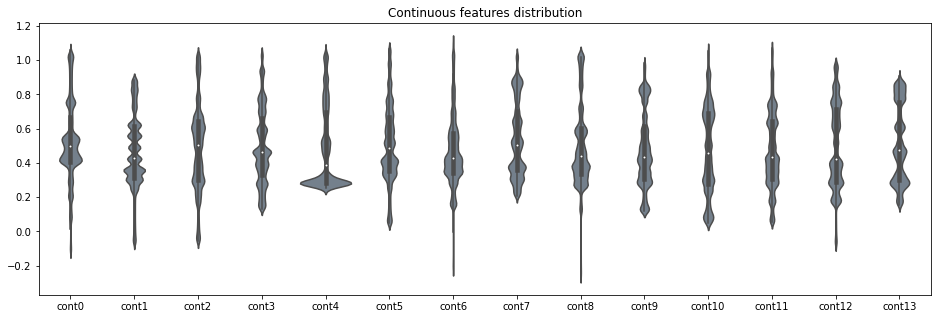

In [48]:
plt.figure(figsize=(16,5))
sns.violinplot(data=train_df[num_features], color='slategray')
plt.title('Continuous features distribution');

どれも歪な気がするが…


In [59]:
for i in range(0,12):
    print(str(i)+":"+str(len(train_df[train_df["target"] <= i])))

0:0
1:5
2:11
3:24
4:73
5:176
6:372
7:4687
8:109659
9:251098
10:295430
11:300000


6以下を切ってみる

In [63]:
to_drop = train_df[train_df["target"] <= 6].index
ex_df = train_df.drop(to_drop)



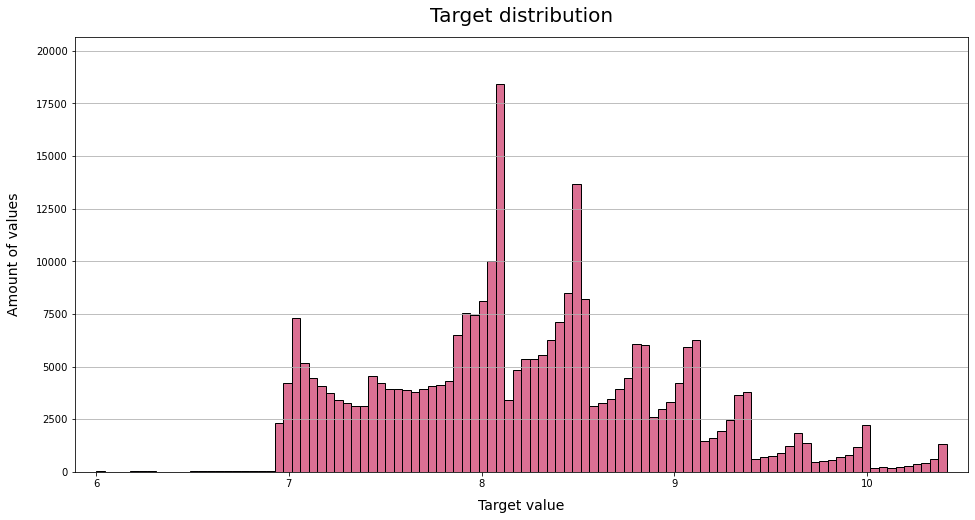

In [64]:
fig, ax = plt.subplots(figsize=(16, 8))

bars = ax.hist(ex_df["target"],
               bins=100,
               color="palevioletred",
               edgecolor="black")
ax.set_title("Target distribution", fontsize=20, pad=15)
ax.set_ylabel("Amount of values", fontsize=14, labelpad=15)
ax.set_xlabel("Target value", fontsize=14, labelpad=10)
ax.margins(0.025, 0.12)
ax.grid(axis="y")

plt.show();

なんだこの分布は
→多峰性分布というらしい

## 0820_cats-on-a-hot-tin-roof-cats-encoding-methods

ターゲットエンコーディングを試してみたい

In [51]:
#コピーをとっておく
tr_orig = train_df.copy()
ts_orig = test_df.copy()

目的変数の外れ値の処理のみ行う（カテゴリ変数は文字間で開きがあると厄介のなので処理しない）

In [52]:
to_drop = tr_orig[tr_orig["target"] <= 6].index
tr_orig = tr_orig.drop(to_drop)

In [53]:
train = tr_orig.copy()
test = ts_orig.copy()
target = train.pop('target')

pop(要素)で要素を削除

In [54]:
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

In [55]:
def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [56]:
smoothing =1
import category_encoders as ce
oof = pd.DataFrame([])
from sklearn.model_selection import KFold
for tr_idx, oof_idx in KFold(n_splits=5, random_state=2020, shuffle=True).split(train, target):
    ce_target_encoder = ce.TargetEncoder(cols = cat_features, smoothing=smoothing)
    ce_target_encoder.fit(train.iloc[tr_idx, :], target.iloc[tr_idx])
    oof = oof.append(ce_target_encoder.transform(train.iloc[oof_idx, :]), ignore_index=False)
ce_target_encoder = ce.TargetEncoder(cols = cat_features, smoothing=smoothing)
ce_target_encoder.fit(train, target);  train = oof.sort_index(); test = ce_target_encoder.transform(test)

/Users/naokitakahashi/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Users/naokitakahashi/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Users/naokitakahashi/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Users/naokitakahashi/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.type

In [57]:
ss = StandardScaler()
train[num_features] = ss.fit_transform(train[num_features])
test[num_features]  = ss.transform(test[num_features])

In [58]:
score = []

oof_rg = np.zeros(len(train))
pred_rg = np.zeros(len(test))

folds = KFold(n_splits=5, shuffle=True, random_state=42)

for fold_ , (train_ind, val_ind) in enumerate(folds.split(train, target)):
    print('fold:', fold_, '  - Starting ...')
    trn_data, val_data = train.iloc[train_ind], train.iloc[val_ind]
    y_train, y_val = target.iloc[train_ind], target.iloc[val_ind]
    
    rg = Ridge(alpha=0.1, random_state=2021)
    rg.fit(trn_data, y_train)
    oof_rg[val_ind] = rg.predict(val_data)
    y = rg.predict(trn_data)
    print('train rmse:' , np.sqrt(mean_squared_error(y_train, y)),'val rmse:' , np.sqrt(mean_squared_error(y_val, oof_rg[val_ind])))
    
    score.append(np.sqrt(mean_squared_error(y_val, oof_rg[val_ind])))
    pred_rg += rg.predict(test)/folds.n_splits
    
print('-'*50)
print(' Model rmse:  ', np.mean(score))

fold: 0   - Starting ...
train rmse: 0.727666125336997 val rmse: 0.7304767630984884
fold: 1   - Starting ...
train rmse: 0.7277539073335666 val rmse: 0.730130095613227
fold: 2   - Starting ...
train rmse: 0.72946617625806 val rmse: 0.7232536623989646
fold: 3   - Starting ...
train rmse: 0.7281618947412916 val rmse: 0.7285111810661132
fold: 4   - Starting ...
train rmse: 0.7280205023963024 val rmse: 0.7290576746170249
--------------------------------------------------
 Model rmse:   0.7282858753587637


In [31]:
train.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
0,1,8.251332,8.209546,8.227788,8.241641,8.245326,8.234158,8.245383,8.245193,8.287095,8.251951,-1.413322,-2.223104,0.707309,-1.644138,0.496072,-0.482632,-1.460643,-1.037233,-0.454330,-0.950914,-0.927028,-0.429520,-0.696546,1.621784
1,2,8.250315,8.207999,8.247950,8.281281,8.244394,8.252772,8.244277,8.316867,8.234013,8.247095,0.935232,-0.437000,2.096319,-0.597036,-0.894641,0.098890,0.434902,-0.095807,0.401944,-0.612027,1.685731,2.019751,-0.940901,-0.193695
2,3,8.244856,8.282274,8.250938,8.242615,8.246604,8.256504,8.246431,8.259961,8.237675,8.264941,0.933673,-0.703478,-1.986079,0.366300,-0.860394,0.613805,-0.437960,1.674873,0.236391,1.691036,1.071529,0.661530,0.189360,1.146329
3,4,8.251915,8.208853,8.249131,8.241451,8.245384,8.254865,8.245249,8.245205,8.285283,8.276940,-0.424285,0.747967,0.345134,-0.985676,-0.862089,0.694293,-1.085983,0.897339,0.754899,0.458586,-0.502218,1.087065,0.184006,-1.020778
4,6,8.243657,8.280101,8.248005,8.240669,8.244382,8.254368,8.244639,8.243812,8.234872,8.254655,2.302147,-0.436618,-2.142842,-1.205586,-0.849892,0.773091,-0.222475,0.508771,0.775251,2.210103,2.055960,1.366890,0.530564,-1.154701


このnotebookの中で一番精度が良いものを試してみる

In [33]:
train_lc = tr_orig.copy()
test_lc = ts_orig.copy()

target_lc = train_lc.pop('target')

In [37]:
for c in cat_features:
    le=LabelEncoder()
    le.fit(list(train_lc[c].astype('str')) + list(test_lc[c].astype('str')))
    train_lc[c] = le.transform(list(train_lc[c].astype(str))) 
    test_lc[c] = le.transform(list(test_lc[c].astype(str))) 
train_lc.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
0,1,1,1,1,2,1,1,0,4,2,13,0.201470,-0.014822,0.669699,0.136278,0.610706,0.400361,0.160266,0.310921,0.389470,0.267559,0.237281,0.377873,0.322401,0.869850
1,2,1,1,0,0,1,3,0,5,0,14,0.743068,0.367411,1.021605,0.365798,0.276853,0.533087,0.558922,0.516294,0.594928,0.341439,0.906013,0.921701,0.261975,0.465083
2,3,0,0,0,2,1,3,0,3,0,5,0.742708,0.310383,-0.012673,0.576957,0.285074,0.650609,0.375348,0.902567,0.555205,0.843531,0.748809,0.620126,0.541474,0.763846
3,4,1,1,0,2,1,3,0,4,2,10,0.429551,0.620998,0.577942,0.280610,0.284667,0.668980,0.239061,0.732948,0.679618,0.574844,0.346010,0.714610,0.540150,0.280682
4,6,0,0,0,2,1,3,0,4,0,13,1.058291,0.367492,-0.052389,0.232407,0.287595,0.686964,0.420667,0.648182,0.684501,0.956692,1.000773,0.776742,0.625849,0.250823


In [38]:
SEED = 8970365

In [39]:
lgb_params = {
    
 'objective': 'rmse', 
 'boosting': 'gbdt', 
 'bagging_fraction': 0.7,
 'bagging_frequency': 1,
 'cat_smooth': 200,
 'feature_fraction': 0.7,
 'learning_rate': 0.01,
 'min_child_samples': 50,
 'min_data_per_group': 200,
 'num_leaves': 10,
 'reg_alpha': 2.,
 'reg_lambda': 3., 
 'metric':'rmse', 
 }

In [41]:
oof_lgb = np.zeros(len(train))
pred_lgb = np.zeros(len(test))

scores = []

feature_importances_gain = pd.DataFrame()
feature_importances_gain['feature'] = train.columns

feature_importances_split = pd.DataFrame()
feature_importances_split['feature'] = train.columns


folds = KFold(n_splits=3, shuffle=True, random_state=42)

for fold_, (train_ind, val_ind) in enumerate(folds.split(train, target)):
    print("fold : ---------------------------------------", fold_)
    trn_data = lgb.Dataset(train.iloc[train_ind], label=target.iloc[train_ind], categorical_feature=cat_features) #-------> Specify Categorical feature for lgb
    val_data= lgb.Dataset(train.iloc[val_ind], label=target.iloc[val_ind], categorical_feature=cat_features)  #-------> Specify Categorical feature for lgb
    
    lgb_clf = lgb.train(lgb_params, trn_data, num_boost_round=3000, valid_sets=(trn_data, val_data), verbose_eval=100, early_stopping_rounds=100)
    oof_lgb[val_ind] = lgb_clf.predict(train.iloc[val_ind], num_iteration= lgb_clf.best_iteration)
    
    scores.append(np.sqrt(mean_squared_error(target.iloc[val_ind], oof_lgb[val_ind])))
    
    feature_importances_gain['fold_{}'.format(fold_ + 1)] = lgb_clf.feature_importance(importance_type='gain')
    feature_importances_split['fold_{}'.format(fold_ + 1)] = lgb_clf.feature_importance(importance_type='split')
    
    pred_lgb += lgb_clf.predict(test, num_iteration=lgb_clf.best_iteration)/folds.n_splits
    
print(np.mean(scores))

fold : --------------------------------------- 0
[LightGBM] [Warning] Unknown parameter: bagging_frequency


/Users/naokitakahashi/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010727 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 199752, number of used features: 15
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Info] Start training from score 8.245034
Training until validation scores don't improve for 100 rounds


/Users/naokitakahashi/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/naokitakahashi/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[100]	training's rmse: 0.729201	valid_1's rmse: 0.732896
[200]	training's rmse: 0.726186	valid_1's rmse: 0.730086
[300]	training's rmse: 0.724031	valid_1's rmse: 0.728133
[400]	training's rmse: 0.72223	valid_1's rmse: 0.726529
[500]	training's rmse: 0.720772	valid_1's rmse: 0.725241
[600]	training's rmse: 0.719561	valid_1's rmse: 0.7242
[700]	training's rmse: 0.718544	valid_1's rmse: 0.723351
[800]	training's rmse: 0.717613	valid_1's rmse: 0.722594
[900]	training's rmse: 0.71678	valid_1's rmse: 0.721928
[1000]	training's rmse: 0.716026	valid_1's rmse: 0.72134
[1100]	training's rmse: 0.715337	valid_1's rmse: 0.720811
[1200]	training's rmse: 0.714719	valid_1's rmse: 0.720328
[1300]	training's rmse: 0.714175	valid_1's rmse: 0.719936
[1400]	training's rmse: 0.713624	valid_1's rmse: 0.719524
[1500]	training's rmse: 0.71313	valid_1's rmse: 0.719179
[1600]	training's rmse: 0.712677	valid_1's rmse: 0.718877
[1700]	training's rmse: 0.712277	valid_1's rmse: 0.71865
[1800]	training's rmse: 0.7118

/Users/naokitakahashi/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 199752, number of used features: 15
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Info] Start training from score 8.247056
Training until validation scores don't improve for 100 rounds


/Users/naokitakahashi/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/naokitakahashi/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[100]	training's rmse: 0.731568	valid_1's rmse: 0.727953
[200]	training's rmse: 0.728413	valid_1's rmse: 0.725248
[300]	training's rmse: 0.726116	valid_1's rmse: 0.723324
[400]	training's rmse: 0.724358	valid_1's rmse: 0.721907
[500]	training's rmse: 0.722912	valid_1's rmse: 0.720745
[600]	training's rmse: 0.721654	valid_1's rmse: 0.719716
[700]	training's rmse: 0.720578	valid_1's rmse: 0.718868
[800]	training's rmse: 0.719621	valid_1's rmse: 0.718112
[900]	training's rmse: 0.718752	valid_1's rmse: 0.717433
[1000]	training's rmse: 0.717951	valid_1's rmse: 0.716812
[1100]	training's rmse: 0.717249	valid_1's rmse: 0.716293
[1200]	training's rmse: 0.716588	valid_1's rmse: 0.715802
[1300]	training's rmse: 0.715986	valid_1's rmse: 0.715373
[1400]	training's rmse: 0.715452	valid_1's rmse: 0.715012
[1500]	training's rmse: 0.71497	valid_1's rmse: 0.714703
[1600]	training's rmse: 0.714524	valid_1's rmse: 0.714437
[1700]	training's rmse: 0.714094	valid_1's rmse: 0.71419
[1800]	training's rmse: 0

/Users/naokitakahashi/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 199752, number of used features: 15
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Info] Start training from score 8.246616
Training until validation scores don't improve for 100 rounds


/Users/naokitakahashi/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/naokitakahashi/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[100]	training's rmse: 0.730053	valid_1's rmse: 0.731041
[200]	training's rmse: 0.727114	valid_1's rmse: 0.728379
[300]	training's rmse: 0.724907	valid_1's rmse: 0.726424
[400]	training's rmse: 0.723109	valid_1's rmse: 0.724853
[500]	training's rmse: 0.721641	valid_1's rmse: 0.723629
[600]	training's rmse: 0.720382	valid_1's rmse: 0.722567
[700]	training's rmse: 0.719319	valid_1's rmse: 0.721693
[800]	training's rmse: 0.718378	valid_1's rmse: 0.720929
[900]	training's rmse: 0.717508	valid_1's rmse: 0.720205
[1000]	training's rmse: 0.716737	valid_1's rmse: 0.719582
[1100]	training's rmse: 0.716025	valid_1's rmse: 0.719015
[1200]	training's rmse: 0.715369	valid_1's rmse: 0.718492
[1300]	training's rmse: 0.714774	valid_1's rmse: 0.718054
[1400]	training's rmse: 0.71425	valid_1's rmse: 0.717692
[1500]	training's rmse: 0.713756	valid_1's rmse: 0.717368
[1600]	training's rmse: 0.71332	valid_1's rmse: 0.717103
[1700]	training's rmse: 0.712909	valid_1's rmse: 0.716877
[1800]	training's rmse: 0

In [43]:
predictions = lgb_clf.predict(test_lc, num_iteration= lgb_clf.best_iteration)

In [44]:
predictions[:5]

array([8.32667519, 8.47925976, 8.36434999, 8.24868472, 8.19022263])

In [47]:
submission = pd.read_csv("../data/original/sample_submission.csv")

In [48]:
submission.target = predictions

In [49]:
submission.head()

,id,target
0,0,8.326675
1,5,8.479260
2,15,8.364350
3,16,8.248685
4,17,8.190223


In [50]:
submission.to_csv("../data/submit/submission_2.csv", index=False)

In [59]:
predictions_rg = rg.predict(test)

In [60]:
submission_rg = pd.read_csv("../data/original/sample_submission.csv")

In [61]:
submission_rg.target = predictions_rg

In [62]:
submission_rg.to_csv("../data/submit/submission_3.csv", index=False)